# PyTorch Workflow

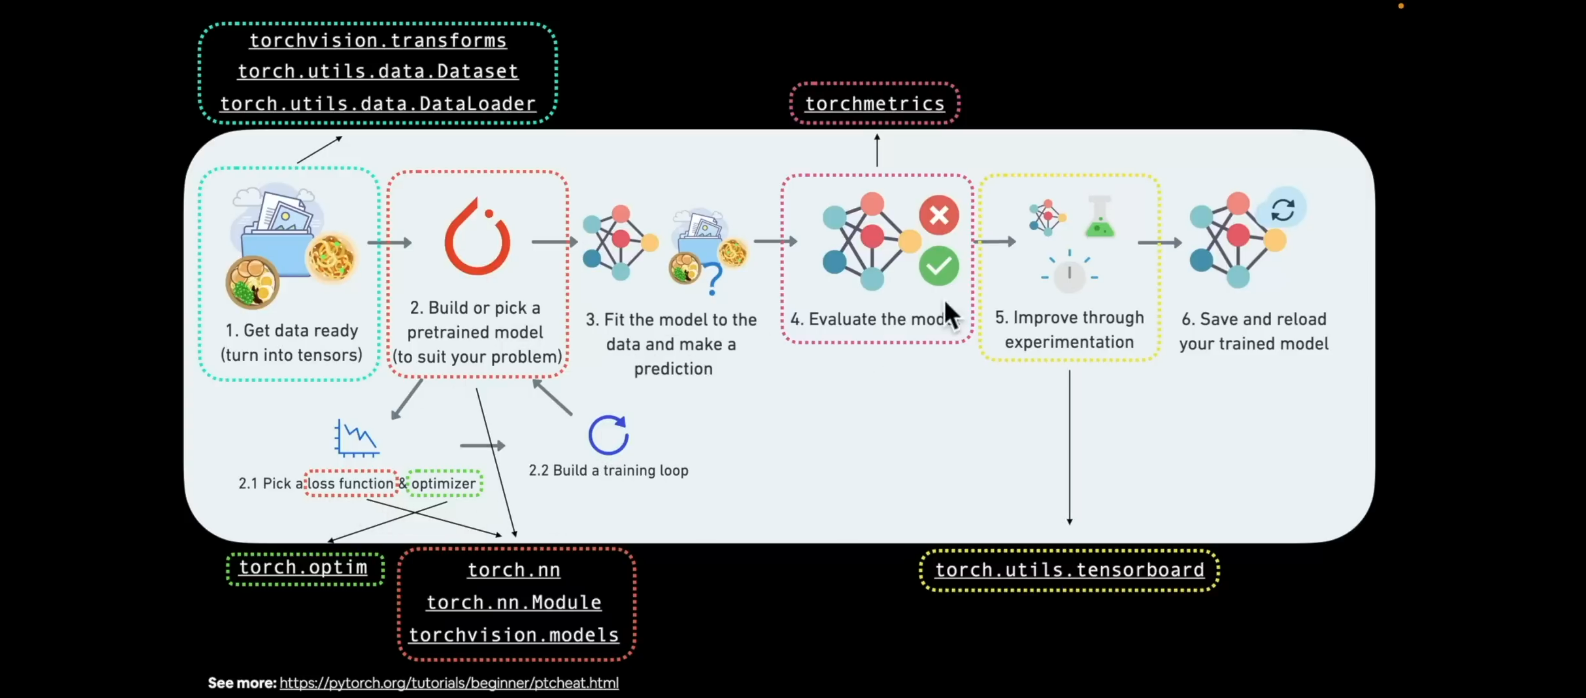

### What will this notebook cover?
1. data prepare and load
2. build model
3. fitting the model to the data (training)
4. making predictions and evaluating a model (inference)
5. saving and loading a model
6. putting it all together

### Importing dependencies

In [1]:
import torch 
from torch import nn
import numpy as np
import matplotlib.pyplot as plt 

## 1. Getting Data Ready

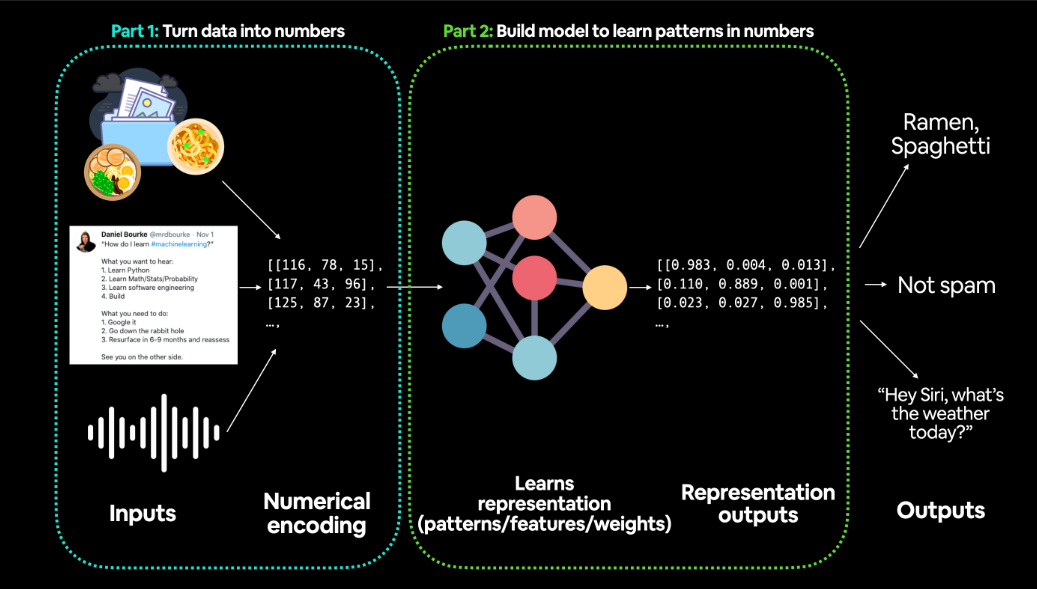

In [2]:
# create known parameters 
weight = 0.8
bias = 0.3

X = torch.arange(start=0, end=1, step=0.02).unsqueeze(dim=1)
y = weight*X + bias
X[:10,], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3160],
         [0.3320],
         [0.3480],
         [0.3640],
         [0.3800],
         [0.3960],
         [0.4120],
         [0.4280],
         [0.4440]]))

In [3]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets

In [4]:
train_split = int(0.8*len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

### Visualizing the data

In [5]:
def plot_predictions(train_data = X_train,
                     train_label = y_train,
                     test_data = X_test,
                     test_label = y_test,
                     predictions = None):
    """
    plots the training, test data and compare predictions.
    """
    plt.figure(figsize=(9,6))
  
    # Plot training data in blue
    plt.scatter(train_data, train_label, color='b', s=4, label='Training Data')
    
    # Plot the test data in green
    plt.scatter(test_data, test_label, color='g', s=4, label='Test Data')

    # Plot predictions if they exist
    if predictions is not None:
        plt.scatter(test_data, predictions, color='r', s=4, label='Predictions')

    # Show the legend
    plt.legend(prop={'size': 14})

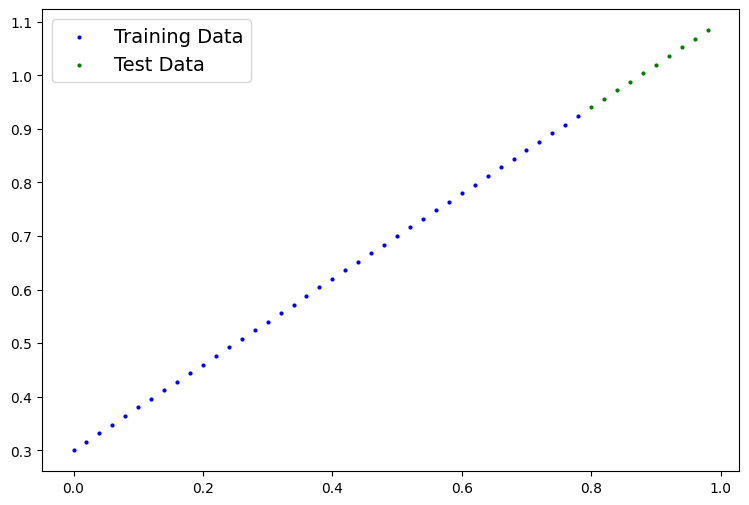

In [6]:
plot_predictions()

## 2. Building Model

Let's create a linear regression model.

#### What our model does?
* Start with random parameters (weight & bias)
* Look at the training data and adjust the random values to better represent the ideal values (the weight & bias we used to create the data)

#### How does it do so?

Through two algorithms:
1. Gradient Descent [Learn](https://youtu.be/IHZwWFHWa-w)
2. Back Propagation [Learn](https://youtu.be/Ilg3gGewQ5U)



![a pytorch linear model with annotations](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-linear-model-annotated.png)

In [7]:
# Create Linear Regression model class 
class LinearRegressionModel(nn.Module):  # almost everything in PyTorch inherits from nn.Module
    def __init__(self):
        super().__init__()

        # Initialize model parameters
        self.weights = nn.Parameter(torch.randn(1,    # start with a random weight and  
                                                requires_grad=True,  # can this parameter be updated via gradient descent
                                                dtype=torch.float))  # PyTorch loves torch.float32 dtype
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    # Forward method to define the computation in the method
    def forward(self, x: torch.Tensor) -> torch.Tensor:  # x is the input data 
        return self.weights*x + self.bias  # Linear Regression formula

### Model building essentials

| PyTorch module | What does it do? |
| ----- | ----- |
| [`torch.nn`](https://pytorch.org/docs/stable/nn.html) | Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way). |
| [`torch.nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#parameter) | Stores tensors that can be used with `nn.Module`. If `requires_grad=True` gradients (used for updating model parameters via [**gradient descent**](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html))  are calculated automatically, this is often referred to as "autograd".  | 
| [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) | The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method be implemented. | 
| [`torch.optim`](https://pytorch.org/docs/stable/optim.html) | Contains various optimization algorithms (these tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss). | 
| `def forward()` | All `nn.Module` subclasses require a `forward()` method, this defines the computation that will take place on the data passed to the particular `nn.Module` (e.g. the linear regression formula above). |

If the above sounds complex, think of like this, almost everything in a PyTorch neural network comes from `torch.nn`,
* `nn.Module` contains the larger building blocks (layers)
* `nn.Parameter` contains the smaller parameters like weights and biases (put these together to make `nn.Module`(s))
* `forward()` tells the larger blocks how to make calculations on inputs (tensors full of data) within  `nn.Module`(s)
* `torch.optim` contains optimization methods on how to improve the parameters within `nn.Parameter` to better represent input data 

Learn more at PyTorch cheatsheet: <https://pytorch.org/tutorials/beginner/ptcheat.html>

### Checking the contents of PyTorch model

We can check the model parameters using `.parameters()`

In [8]:
# Create a random seed 
torch.manual_seed(42)

# create a subclass of the model (this is the instance of nn.Module)
model_0 = LinearRegressionModel()

#check out the paremeters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making Prediction (untrained model) `torch.inference_mode()`
To check this we can pass it the test data `X_test` to see how closely it predicts `y_test`.

When we pass data to our model, it'll go through the model's `forward()` method and produce a result using the computation we've defined. 

Let's make some predictions. 

In [10]:
# Make predictions with model
with torch.inference_mode():  # doesn't keep gradients and doesn't store computation graph
    y_preds = model_0(X_test)

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)
# torch.no_grad() stores computation graph

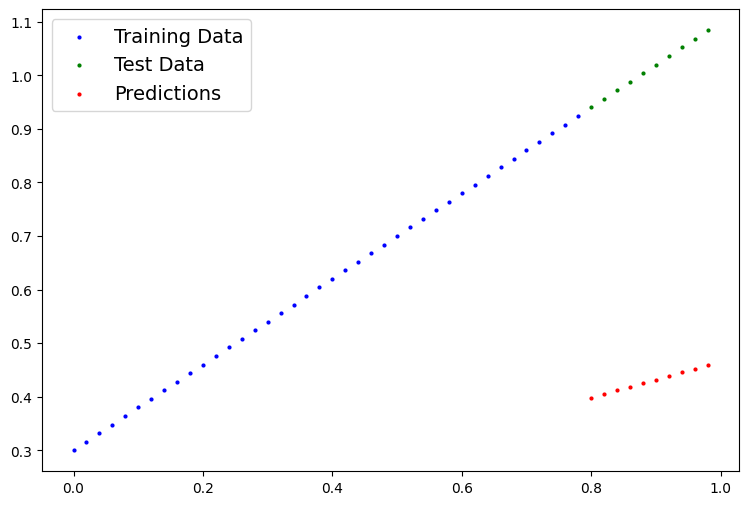

In [11]:
plot_predictions(predictions=y_preds)

## 3. Training Model [🔗](https://pytorch.org/docs/stable/nn.html#loss-functions)
The objective of training a model is for a model to move from some *unknown* parameters to *known* parameters

In other words, from a poor representation of data to a better representation

One way to measure how poor the model predictions are is to use a **loss function**
* Note: Loss function may also be called cost function or criterion in different areas.

Things we need to train:
* **Loss Function:** Measures how wrong the outputs are to the ideal outputs, lower is better. [Learn more](https://pytorch.org/docs/stable/nn.html#loss-functions)
* **Optimizer:** Takes into account the loss of a model and adjusts the parameters (weights, bias) to improve the loss function. [Learn more](https://pytorch.org/docs/stable/nn.html#loss-functions)
    * Inside the optimizer, we need to set 2 parameters:
      * `params`: the model parameters we're optimizing `params = model_0.parameters()`
      * `lr`: learning rate is a hyperparamter that defines how big changes the optimizer will make with each step.

Specifically for PyTorch, we need:
* A training loop
* A testing 


| Function | What does it do? | Where does it live in PyTorch? | Common values |
| ----- | ----- | ----- | ----- |
| **Loss function** | Measures how wrong your model's predictions (e.g. `y_preds`) are compared to the truth labels (e.g. `y_test`). Lower the better. | PyTorch has plenty of built-in loss functions in [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions). | Mean absolute error (MAE) for regression problems ([`torch.nn.L1Loss()`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)). Binary cross entropy for binary classification problems ([`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)).  |
| **Optimizer** | Tells your model how to update its internal parameters to best lower the loss. | You can find various optimization function implementations in [`torch.optim`](https://pytorch.org/docs/stable/optim.html). | Stochastic gradient descent ([`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)). Adam optimizer ([`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)). |

In [12]:
# List model parameters 
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [13]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [14]:
# Setup the loss function
loss_fn = nn.L1Loss()

# Setup the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

**Note:** The selection of loss function and optimizer is problem specific.

For a Linear Regression Model, `nn.L1Loss()` and `torch.optim.SGD()` may suffice but for Classification modle we use `nn.BCELoss()` (Binary Cross Entropy)

#### Training Loop

A couple of things we need in a training loop:

0. Loop through the data.
1. Forward pass (this involves data moving throught our model's `forward()` functions) to make predictions on data.(**Forward Propagation**)
3. Calculate the loss (compare forward pass predictions to ground truth labels).
4. Optimizer zero grad
5. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model wrt the loss (**Back Propagation**). 
6. Optimizer step - use the optimizer to adjust the modle's parameters tor try and improve the loss (**Gradient Descent**).

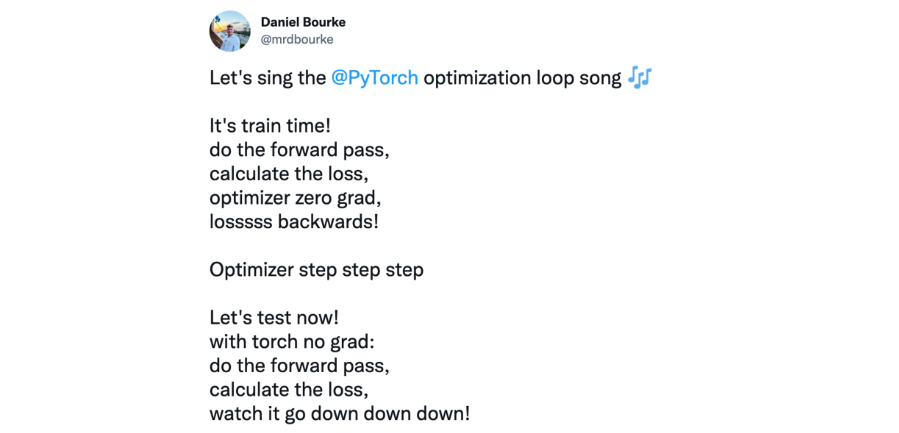

![pytorch training loop annotated](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-training-loop-annotated.png)

#### Testing Loop
As for the testing loop (evaluating our model), the typical steps include:

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the testing data once, performing its `forward()` function calculations. | `model(x_test)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_test)` | 
| 3 | Calulate evaluation metrics (optional) | Alongside the loss value you may want to calculate other evaluation metrics such as accuracy on the test set. | Custom functions |

Notice the testing loop doesn't contain performing backpropagation (`loss.backward()`) or stepping the optimizer (`optimizer.step()`), this is because no parameters in the model are being changed during testing, they've already been calculated. For testing, we're only interested in the output of the forward pass through the model.
![pytorch annotated testing loop](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-testing-loop-annotated.png)

In [16]:
from tqdm import tqdm

torch.manual_seed(42)

# create the no. of loop 
epochs = 300

# Track the different values
epoch_count = []
train_loss_values = []
test_loss_values = []

# 0. loop through the data
for epoch in tqdm(range(epochs)):
    # Set the model to train mmodel
    model_0.train()
    
    # 1. Forward Propagation
    y_pred = model_0(X_train)

    # 2. Calculate the loss 
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform Back Propagation wrt the parameters
    loss.backward()

    # 5. Step the optimizer (Gradient Descent)
    optimizer.step()  # by default how the optimizer changes will accumulate through the loop
                      # so we have to zero them in step 3 for the next iteration of loop 
    ## Testing
    model_0.eval()    # turns off different settings in the model not needed for evaluation/testing (dropout, batch-norm layers)
    with torch.inference_mode(): # turns off gradient tracking and doesn't store computation graph
        # 1. Forward Propagation
        test_pred = model_0(X_test)

        # 2. Claculate the loss 
        test_loss = loss_fn(test_pred, y_test)

        # print out what's happening every 10 epochs
        if epoch%10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss)
            test_loss_values.append(test_loss)
            print(f'Epoch: {epoch:3d}| Loss: {loss:.6f}| Test Loss: {test_loss:.6f}')

print(model_0.state_dict())
    
    
    

    

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 209.32it/s]

Epoch:   0| Loss: 0.351881| Test Loss: 0.570065
Epoch:  10| Loss: 0.236671| Test Loss: 0.435355
Epoch:  20| Loss: 0.126927| Test Loss: 0.305234
Epoch:  30| Loss: 0.079223| Test Loss: 0.219575
Epoch:  40| Loss: 0.065181| Test Loss: 0.173091
Epoch:  50| Loss: 0.059824| Test Loss: 0.148627
Epoch:  60| Loss: 0.056087| Test Loss: 0.134895
Epoch:  70| Loss: 0.052597| Test Loss: 0.123875
Epoch:  80| Loss: 0.049129| Test Loss: 0.114229
Epoch:  90| Loss: 0.045694| Test Loss: 0.105956
Epoch: 100| Loss: 0.042256| Test Loss: 0.098371
Epoch: 110| Loss: 0.038827| Test Loss: 0.090098
Epoch: 120| Loss: 0.035390| Test Loss: 0.081826
Epoch: 130| Loss: 0.031954| Test Loss: 0.074240
Epoch: 140| Loss: 0.028525| Test Loss: 0.065967
Epoch: 150| Loss: 0.025087| Test Loss: 0.057695
Epoch: 160| Loss: 0.021652| Test Loss: 0.050109
Epoch: 170| Loss: 0.018222| Test Loss: 0.041837
Epoch: 180| Loss: 0.014783| Test Loss: 0.033564
Epoch: 190| Loss: 0.011350| Test Loss: 0.025979
Epoch: 200| Loss: 0.007918| Test Loss: 0

In [17]:
train_loss_values_np = np.array(torch.tensor(train_loss_values).numpy())
test_loss_values_np = np.array(torch.tensor(test_loss_values).numpy())

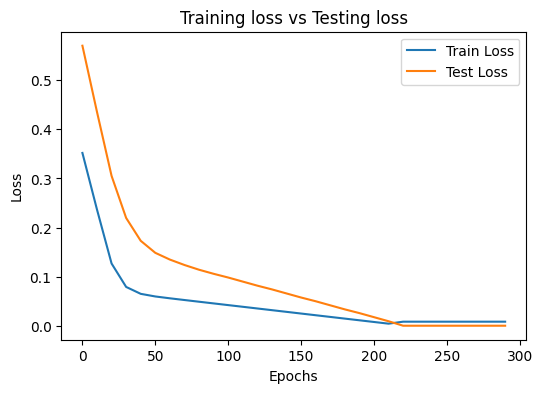

In [18]:
# Plot the loss curves
plt.figure(figsize=(6,4))
plt.plot(epoch_count, train_loss_values_np, label = 'Train Loss')
plt.plot(epoch_count, test_loss_values_np, label = 'Test Loss')
plt.title('Training loss vs Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## 4. Making predictions with a trained PyTorch model (inference)

Once you've trained a model, you'll likely want to make predictions with it.

We've already seen a glimpse of this in the training and testing code above, the steps to do it outside of the training/testing loop are similar.

There are three things to remember when making predictions (also called performing inference) with a PyTorch model:

1. Set the model in evaluation mode (`model.eval()`).
2. Make the predictions using the inference mode context manager (`with torch.inference_mode(): ...`).
3. All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).

The first two items make sure all helpful calculations and settings PyTorch uses behind the scenes during training but aren't necessary for inference are turned off (this results in faster computation). And the third ensures that you won't run into cross-device errors.

In [20]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[0.9275],
        [0.9433],
        [0.9591],
        [0.9749],
        [0.9907],
        [1.0065],
        [1.0223],
        [1.0381],
        [1.0539],
        [1.0697]])

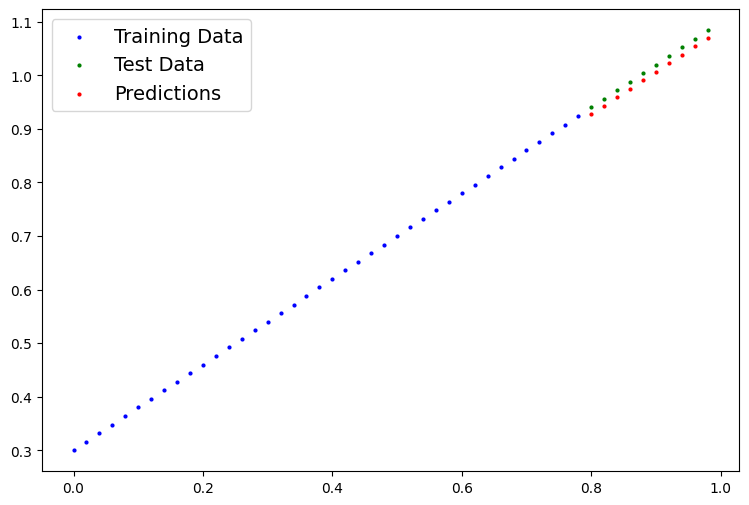

In [21]:
plot_predictions(predictions=y_preds)

## 5. Saving and loading a PyTorch model

If you've trained a PyTorch model, chances are you'll want to save it and export it somewhere.

As in, you might train it on Google Colab or your local machine with a GPU but you'd like to now export it to some sort of application where others can use it. 

Or maybe you'd like to save your progress on a model and come back and load it back later.

For saving and loading models in PyTorch, there are three main methods you should be aware of (all of below have been taken from the [PyTorch saving and loading models guide](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference)):

| PyTorch method | What does it do? | 
| ----- | ----- |
| [`torch.save`](https://pytorch.org/docs/stable/torch.html?highlight=save#torch.save) | Saves a serialized object to disk using Python's [`pickle`](https://docs.python.org/3/library/pickle.html) utility. Models, tensors and various other Python objects like dictionaries can be saved using `torch.save`.  | 
| [`torch.load`](https://pytorch.org/docs/stable/torch.html?highlight=torch%20load#torch.load) | Uses `pickle`'s unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc). |
| [`torch.nn.Module.load_state_dict`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=load_state_dict#torch.nn.Module.load_state_dict)| Loads a model's parameter dictionary (`model.state_dict()`) using a saved `state_dict()` object. | 

> **Note:** As stated in [Python's `pickle` documentation](https://docs.python.org/3/library/pickle.html), the `pickle` module **is not secure**. That means you should only ever unpickle (load) data you trust. That goes for loading PyTorch models as well. Only ever use saved PyTorch models from sources you trust.


### Saving a PyTorch model's `state_dict()`

The [recommended way](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference) for saving and loading a model for inference (making predictions) is by saving and loading a model's `state_dict()`.

Let's see how we can do that in a few steps:

1. We'll create a directory for saving models to called `models` using Python's `pathlib` module.
2. We'll create a file path to save the model to.
3. We'll call `torch.save(obj, f)` where `obj` is the target model's `state_dict()` and `f` is the filename of where to save the model.

> **Note:** It's common convention for PyTorch saved models or objects to end with `.pt` or `.pth`, like `saved_model_01.pth`.


In [22]:
# Saving PyTorch Model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create models save path 
MODEL_NAME = '01-PyTorch_Workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Model Save
print(f'Model Saved to: {MODEL_SAVE_PATH}')
torch.save(obj = model_0.state_dict(), f=MODEL_SAVE_PATH)


Model Saved to: models\01-PyTorch_Workflow_model_0.pth


### Loading a saved PyTorch model's `state_dict()`

Since we've now got a saved model `state_dict()` at `models/01_pytorch_workflow_model_0.pth` we can now load it in using `torch.nn.Module.load_state_dict(torch.load(f))` where `f` is the filepath of our saved model `state_dict()`.

Why call `torch.load()` inside `torch.nn.Module.load_state_dict()`? 

Because we only saved the model's `state_dict()` which is a dictionary of learned parameters and not the *entire* model, we first have to load the `state_dict()` with `torch.load()` and then pass that `state_dict()` to a new instance of our model (which is a subclass of `nn.Module`).

Why not save the entire model?

[Saving the entire model](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-entire-model) rather than just the `state_dict()` is more intuitive, however, to quote the PyTorch documentation (italics mine):

> The disadvantage of this approach *(saving the whole model)* is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved...
>
> Because of this, your code can break in various ways when used in other projects or after refactors.

So instead, we're using the flexible method of saving and loading just the `state_dict()`, which again is basically a dictionary of model parameters.

Let's test it out by creating another instance of `LinearRegressionModel()`, which is a subclass of `torch.nn.Module` and will hence have the in-built method `load_state_dict()`.

In [23]:
# Create an instance of the model
loaded_model_0 = LinearRegressionModel()

# Load the state dict 
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH)) # We have to deserialize the model state dict before loading in the new model

C:\Users\Dipesh\AppData\Local\Temp\ipykernel_3256\1608333494.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH)

<All keys matched successfully>

In [24]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.7902])), ('bias', tensor([0.2953]))])

## Making Predictions on loaded model 

In [25]:
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)
    loaded_loss = loss_fn(loaded_model_preds, y_test)

loaded_loss

tensor(0.0134)

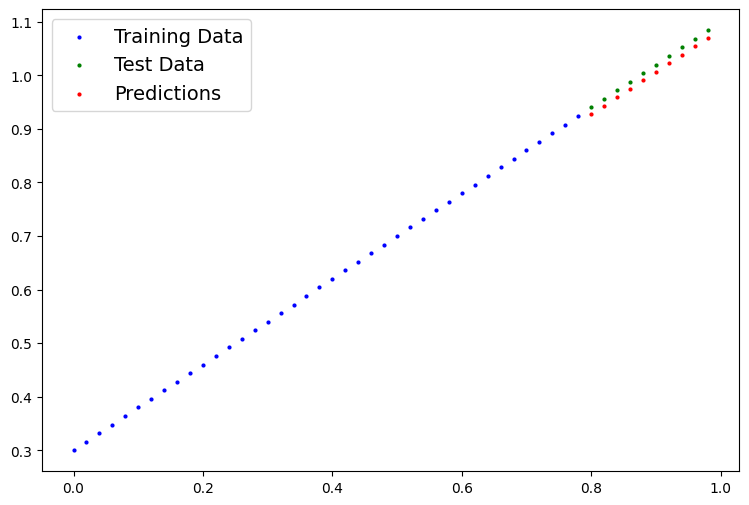

In [26]:
plot_predictions(predictions=loaded_model_preds)